In [1]:
import sys
import os

# Add parent directory to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
from modules.spin_system import SpinSystem

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
# from utils.plots import plot_spin_evolution


2025-09-17 18:06:05.672360: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-17 18:06:05.707644: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-17 18:06:07.161487: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:

def generate_periodic_nn_coupling_tensor(D, L):
    """
    Vectorized nearest-neighbor coupling tensor with periodic boundaries.
    J[i1,...,iD,j1,...,jD] = 1 if periodic Manhattan distance = 1, else 0
    """
    # Generate all coordinates: shape (N, D)
    coords = np.array(np.meshgrid(*[np.arange(L)]*D, indexing='ij')).reshape(D, -1).T
    N = coords.shape[0]

    # Compute pairwise differences with broadcasting
    diff = np.abs(coords[:, None, :] - coords[None, :, :])
    
    # Apply periodic boundary
    diff = np.minimum(diff, L - diff)

    # Manhattan distance
    manhattan_dist = diff.sum(axis=2)

    # Nearest neighbors mask
    nn_mask = (manhattan_dist == 1)

    # Create empty tensor and set neighbors
    J_tensor = np.zeros((L,)*D*2, dtype=np.float32)
    
    # Get indices where nn_mask is True
    idx_i, idx_j = np.nonzero(nn_mask)
    
    # Set values in the tensor
    for i, j in zip(idx_i, idx_j):
        J_tensor[tuple(coords[i]) + tuple(coords[j])] = 1.0

    return J_tensor

I0000 00:00:1758143168.469019   81727 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


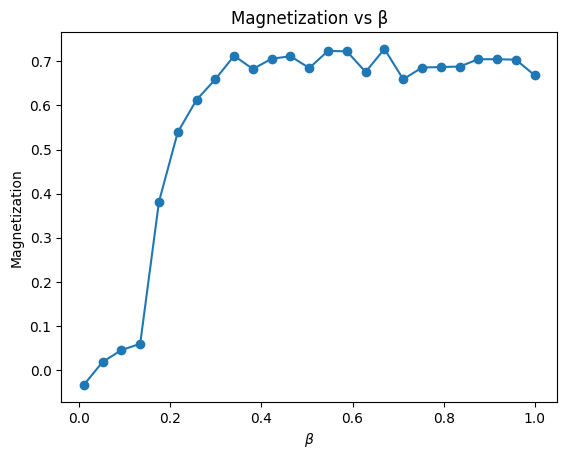

In [4]:
lattice_dim = 2
lattice_length = 60

interaction_matrix = 2*generate_periodic_nn_coupling_tensor(lattice_dim, lattice_length)
spin_system = SpinSystem(
    lattice_dim=lattice_dim,
    lattice_length=lattice_length,
    interaction_matrix=interaction_matrix,
    model="ising",
    initial_magnetization=0.5
)

sweep_length = 20000

# Define the betas you want to simulate
betas = tf.linspace(0.01, 1, 25)  # 10 temperatures from 0.1 to 5.0

# Run multi-temperature sweeps
results = spin_system.multi_temperature_sweep(
    betas=betas,
    num_disturb=tf.constant(2, dtype=tf.int32),
    sweep_length=sweep_length,
    track_spins=False,
    track_energy=False,
    track_magnetization=True
)

# Example: get magnetization evolution
magnetizations = results["magnetization_evolution"]  # shape: [n_betas, sweep_length+1]

final_mags = magnetizations[:, -1].numpy()  # last value of each sweep
plt.plot(betas.numpy(), final_mags, marker='o')
plt.xlabel(r"$\beta$")
plt.ylabel("Magnetization")
plt.title("Magnetization vs β")
plt.show()